# Validation of GGR causal networks on GTEx expression data

This notebook summarizes the results of validating GGR causal networks on GTEx expression data.

# Enrichment of trans-eQTLs and causal signature (MR) among GGR gene pairs

For the set of causal interactions that are proposed by GGR, we want to see if there is an enrichment of trans-eQTL signal between SNPs (that are cis- to the causal gene) and the target gene. First, we need to select the set of SNPs that are within a set distance from the causal gene (20kb, say), and the set of null SNPs that come from randomly selected genes and their cis SNPs. Then, for each gene pair (both causal and random), we select the best trans-SNP for that pair, and compare the distribution of test statistics to measure enrichment.

We do this for 5 tissues:
- Lung (N = 278)
- Adipose Subcutaneous (N = 297)
- Cells, Transformed Fibroblasts (N = 272)
- Artery Tibial (N = 285)
- Thyroid (N = 278)

First, let's take a look at the networks generated by Jonathan: They are deposited at:

<code>/tigress/BEE/RNAseq/Data/Networks/GGR</code>

And there are eight directories:

- 0mean-1var_g-null_g-fdr
- 0mean-unnormalized_g-null_g-fdr
- 0mean-1var_g-null_l-fdr
- 0mean-unnormalized_g-null_l-fdr
- 0mean-1var_l-null_g-fdr
- 0mean-unnormalized_l-null_g-fdr
- 0mean-1var_l-null_l-fdr
- 0mean-unnormalized_l-null_l-fdr

These 8 directories represent 3 conditions: normalization (setting variance to 1 vs. not), null distribution ('global' vs. 'local'), and FDR calibration ('global' vs. 'local')

In each directory, There is a networks subdirectory, which holds 6 files each:

2 for elastic net regression, 2 for lasso, and 2 for ridge (lag 1 and lag 2 for each regression)

## Converting the network files for gene names from hg38 to hg19

First, let's convert the network files, which have gene names in hg38 (gencode v. 22), to gene names in hg19 (gencode v. 19), since the GTEx expression and genotype files are in hg19:

In [ ]:
%%bash

/home/daguiar/bin/clusterize -l 24:00:00 -m 12G -c "python /tigress/BEE/RNAseq/Scripts/causality/GGR/gtex/retrofit_gene_pairs.py /Data/Networks/GGR/ 0mean-1var_g-null_g-fdr /Data/Networks/GGR/retrofitted/ /Data/Expression/gene_metadata_hg19/gene_metadata_chrAll.txt"
/home/daguiar/bin/clusterize -l 24:00:00 -m 12G -c "python /tigress/BEE/RNAseq/Scripts/causality/GGR/gtex/retrofit_gene_pairs.py /Data/Networks/GGR/ 0mean-unnormalized_g-null_g-fdr /Data/Networks/GGR/retrofitted/ /Data/Expression/gene_metadata_hg19/gene_metadata_chrAll.txt"
/home/daguiar/bin/clusterize -l 24:00:00 -m 12G -c "python /tigress/BEE/RNAseq/Scripts/causality/GGR/gtex/retrofit_gene_pairs.py /Data/Networks/GGR/ 0mean-1var_g-null_l-fdr /Data/Networks/GGR/retrofitted/ /Data/Expression/gene_metadata_hg19/gene_metadata_chrAll.txt"
/home/daguiar/bin/clusterize -l 24:00:00 -m 12G -c "python /tigress/BEE/RNAseq/Scripts/causality/GGR/gtex/retrofit_gene_pairs.py /Data/Networks/GGR/ 0mean-unnormalized_g-null_l-fdr /Data/Networks/GGR/retrofitted/ /Data/Expression/gene_metadata_hg19/gene_metadata_chrAll.txt"
/home/daguiar/bin/clusterize -l 24:00:00 -m 12G -c "python /tigress/BEE/RNAseq/Scripts/causality/GGR/gtex/retrofit_gene_pairs.py /Data/Networks/GGR/ 0mean-1var_l-null_g-fdr /Data/Networks/GGR/retrofitted/ /Data/Expression/gene_metadata_hg19/gene_metadata_chrAll.txt"
/home/daguiar/bin/clusterize -l 24:00:00 -m 12G -c "python /tigress/BEE/RNAseq/Scripts/causality/GGR/gtex/retrofit_gene_pairs.py /Data/Networks/GGR/ 0mean-unnormalized_l-null_g-fdr /Data/Networks/GGR/retrofitted/ /Data/Expression/gene_metadata_hg19/gene_metadata_chrAll.txt"
/home/daguiar/bin/clusterize -l 24:00:00 -m 12G -c "python /tigress/BEE/RNAseq/Scripts/causality/GGR/gtex/retrofit_gene_pairs.py /Data/Networks/GGR/ 0mean-1var_l-null_l-fdr /Data/Networks/GGR/retrofitted/ /Data/Expression/gene_metadata_hg19/gene_metadata_chrAll.txt"
/home/daguiar/bin/clusterize -l 24:00:00 -m 12G -c "python /tigress/BEE/RNAseq/Scripts/causality/GGR/gtex/retrofit_gene_pairs.py /Data/Networks/GGR/ 0mean-unnormalized_l-null_l-fdr /Data/Networks/GGR/retrofitted/ /Data/Expression/gene_metadata_hg19/gene_metadata_chrAll.txt"


## Calculate trans-eQTL and MR statistics

After we deposit all the retrofitted pair files into <code>/tigress/BEE/RNAseq/Data/Networks/GGR/retrofitted</code>, we can run the pipeline file which does the following:

#### Read in the expression data, gene positions, covaraites, and also the list of gene pairs to test (Note that the gene pairs have already been converted to gencode v.19
#### Get the list of cis genes to test
#### For each cis gene:
#### - Read in the genotype matrix and snp positions if new chromosome
#### - Get the list of SNPs that are close (20kb) to the TSS of the cis gene
#### - Feed MatrixEQTL with the corresponding expression, gene position, genotype, snp position and covariates
#### Put together all the MatrixEQTL outputs
#### - Save the hist.counts for the p-value enrichment plots
#### - Save the best trans-eQTL, for true and permuted tests, for each gene-gene pair for the qqplot and calculation of $\pi_0$
#### Run MR on each pair by:
#### - calculate the $t_{MR}$ statistic (formula given below) for each SNP_cis-gene_trans-gene triplet
#### - Save the best triplet, for true and permuted tests, for each gene-gene pair for comparison of $t_{MR}$ statistics

\begin{eqnarray}
t_{MR} &=& \frac {\beta_{MR}} {var(\beta_{MR})} \\
&\text{where:}& \\
\beta_{MR} &=& \frac { \hat\beta_{y,z}} {\hat\beta_{x,z}} \\
var(\beta_{MR}) &=& \sigma^2 (x^T P_z x)^{-1} \\
\sigma^2 &=& \frac {(y - x \beta_{MR})^T (y - x \beta_{MR})} {n - \nu} \\
P_z &=& z(z^Tz)^{-1}z^T \\
\end{eqnarray}


In [ ]:
%%bash

python /tigress/BEE/RNAseq/Scripts/causality/GGR/gtex/GGR_validation_pipeline_wrapper.py \
/Data/Expression/gtex/hg19/GTEx_phs000424_v6p/normalized/ _v6p_consortium_autosomes_normalized.txt \
/Data/Networks/GGR/retrofitted/ /Output/causality/GGR/output/all_by_all/ /Output/joblogs/causality/GGR/all_by_all/ \
0mean-1var_g-null_l-fdr 2.5e8 1000 enet-2 enet-1

python /tigress/BEE/RNAseq/Scripts/causality/GGR/gtex/GGR_validation_pipeline_wrapper.py \
/Data/Expression/gtex/hg19/GTEx_phs000424_v6p/normalized/ _v6p_consortium_autosomes_normalized.txt \
/Data/Networks/GGR/retrofitted/ /Output/causality/GGR/output/all_by_all/ /Output/joblogs/causality/GGR/all_by_all/ \
0mean-unnormalized_g-null_l-fdr 2.5e8 1000 enet-2 enet-1

## Results: trans-eQTL enrichment for cause-effect gene pairs

After the trans-eQTL signal is compiled, we look at the number of cause-effect gene pairs that produce significant trans-eQTLs at FDR < 0.1 (calculated by q-value package using the null stats with permuted gene expression), and calculate lung-specific enrichment (compared to four other tissues) using Fisher's exact test.

In [ ]:
%%bash

Rscript /tigress/BEE/RNAseq/Scripts/causality/GGR/gtex/GGR_validation_collect_stats_redux.R \
/tigress/BEE/RNAseq/Output/causality/GGR/output/all_by_all/ /tigress/BEE/RNAseq/Output/causality/GGR/final_list/all_by_all/ \
/tigress/BEE/RNAseq/Analysis/Figures/GGR_validation_plots/all_by_all/ \
0mean-1var_g-null_l-fdr enet-1

Rscript /tigress/BEE/RNAseq/Scripts/causality/GGR/gtex/GGR_validation_collect_stats_redux.R \
/tigress/BEE/RNAseq/Output/causality/GGR/output/all_by_all/ /tigress/BEE/RNAseq/Output/causality/GGR/final_list/all_by_all/ \
/tigress/BEE/RNAseq/Analysis/Figures/GGR_validation_plots/all_by_all/ \
0mean-1var_g-null_l-fdr enet-2

Rscript /tigress/BEE/RNAseq/Scripts/causality/GGR/gtex/GGR_validation_collect_stats_redux.R \
/tigress/BEE/RNAseq/Output/causality/GGR/output/all_by_all/ /tigress/BEE/RNAseq/Output/causality/GGR/final_list/all_by_all/ \
/tigress/BEE/RNAseq/Analysis/Figures/GGR_validation_plots/all_by_all/ \
0mean-unnormalized_g-null_l-fdr enet-1

Rscript /tigress/BEE/RNAseq/Scripts/causality/GGR/gtex/GGR_validation_collect_stats_redux.R \
/tigress/BEE/RNAseq/Output/causality/GGR/output/all_by_all/ /tigress/BEE/RNAseq/Output/causality/GGR/final_list/all_by_all/ \
/tigress/BEE/RNAseq/Analysis/Figures/GGR_validation_plots/all_by_all/ \
0mean-unnormalized_g-null_l-fdr enet-2

<code>
[1] "condition: 0mean-1var_g-null_l-fdr, regression: enet-1"
                            n_below_0.1 ntests  pi_zeros
lung                                 49 439919 0.9243532
adiposesubcutaneous                  31 432803 0.9261619
cellstransformedfibroblasts          33 413605 0.9142911
arterytibial                          0 428456 0.9320660
thyroid                               4 431651 0.9145098
[1] "Fisher's exact test p-value for lung enrichment: 2.0984642426298e-07"

[1] "condition: 0mean-1var_g-null_l-fdr, regression: enet-2"
                            n_below_0.1 ntests  pi_zeros
lung                                  1 540760 0.9411102
adiposesubcutaneous                   0 531757 0.9228177
cellstransformedfibroblasts           0 500121 0.9219855
arterytibial                          0 526586 0.9267347
thyroid                               3 529009 0.9259899
[1] "Fisher's exact test p-value for lung enrichment: 1"

[1] "condition: 0mean-unnormalized_g-null_l-fdr, regression: enet-1"
                            n_below_0.1 ntests  pi_zeros
lung                                  0 944757 0.9193953
adiposesubcutaneous                  10 927541 0.9381822
cellstransformedfibroblasts          46 866749 0.9177356
arterytibial                          1 890326 0.9179147
thyroid                              31 939750 0.9121445
[1] "Fisher's exact test p-value for lung enrichment: 2.40192706755042e-09"

[1] "condition: 0mean-unnormalized_g-null_l-fdr, regression: enet-2"
                            n_below_0.1  ntests  pi_zeros
lung                                  5 1025705 0.9251321
adiposesubcutaneous                   9  991794 0.9341238
cellstransformedfibroblasts          93  946360 0.9212871
arterytibial                          1  917899 0.9106481
thyroid                               0 1029834 0.9266658
[1] "Fisher's exact test p-value for lung enrichment: 4.03825640808412e-06"
</code>

In [ ]:
%%bash

Rscript /tigress/BEE/RNAseq/Scripts/causality/GGR/gtex/GGR_validation_collect_stats.R \
/tigress/BEE/RNAseq/Output/causality/GGR/output/best_cis_only/ /tigress/BEE/RNAseq/Output/causality/GGR/final_list/best_cis_only/ \
/tigress/BEE/RNAseq/Analysis/Figures/GGR_validation_plots/best_cis_only/ \
0mean-1var_g-null_l-fdr enet-1

Rscript /tigress/BEE/RNAseq/Scripts/causality/GGR/gtex/GGR_validation_collect_stats.R \
/tigress/BEE/RNAseq/Output/causality/GGR/output/best_cis_only/ /tigress/BEE/RNAseq/Output/causality/GGR/final_list/best_cis_only/ \
/tigress/BEE/RNAseq/Analysis/Figures/GGR_validation_plots/best_cis_only/ \
0mean-1var_g-null_l-fdr enet-2

Rscript /tigress/BEE/RNAseq/Scripts/causality/GGR/gtex/GGR_validation_collect_stats.R \
/tigress/BEE/RNAseq/Output/causality/GGR/output/best_cis_only/ /tigress/BEE/RNAseq/Output/causality/GGR/final_list/best_cis_only/ \
/tigress/BEE/RNAseq/Analysis/Figures/GGR_validation_plots/best_cis_only/ \
0mean-unnormalized_g-null_l-fdr enet-1

Rscript /tigress/BEE/RNAseq/Scripts/causality/GGR/gtex/GGR_validation_collect_stats.R \
/tigress/BEE/RNAseq/Output/causality/GGR/output/best_cis_only/ /tigress/BEE/RNAseq/Output/causality/GGR/final_list/best_cis_only/ \
/tigress/BEE/RNAseq/Analysis/Figures/GGR_validation_plots/best_cis_only/ \
0mean-unnormalized_g-null_l-fdr enet-2


Compare to the version where only the best cis-SNP was taken:

<code>
[1] "condition: 0mean-1var_g-null_l-fdr, regression: enet-1"
                            n_below_0.1 ntests  pi_zeros
lung                                  1   9283 0.9383657
adiposesubcutaneous                   0   9130 0.9296766
cellstransformedfibroblasts           0   8739 0.8890565
arterytibial                          0   9009 0.9634743
thyroid                               1   9151 0.9021943
[1] "Fisher's exact test p-value for lung enrichment: 0.367790155852116"

[1] "condition: 0mean-1var_g-null_l-fdr, regression: enet-2"
                            n_below_0.1 ntests  pi_zeros
lung                                  2  11991 0.9539712
adiposesubcutaneous                   1  11775 0.9552889
cellstransformedfibroblasts           0  11109 0.9041068
arterytibial                          0  11655 0.9251073
thyroid                               0  11798 0.9312046
[1] "Fisher's exact test p-value for lung enrichment: 0.109429610150677"

[1] "condition: 0mean-unnormalized_g-null_l-fdr, regression: enet-1"
                            n_below_0.1 ntests  pi_zeros
lung                                  1  19547 0.9145709
adiposesubcutaneous                   0  19273 0.9629773
cellstransformedfibroblasts           4  18129 0.9172186
arterytibial                          0  18487 0.9185872
thyroid                               1  19471 0.9086379
[1] "Fisher's exact test p-value for lung enrichment: 1"

[1] "condition: 0mean-unnormalized_g-null_l-fdr, regression: enet-2"
                            n_below_0.1 ntests  pi_zeros
lung                                  1  23109 0.9177363
adiposesubcutaneous                   3  22843 0.9696890
cellstransformedfibroblasts           2  21641 0.9408201
arterytibial                          0  21089 0.9080464
thyroid                               0  23317 0.9392016
[1] "Fisher's exact test p-value for lung enrichment: 1"
</code>

## Testing again with all cis-eQTLs < 1MB

In [ ]:
%%bash

python /tigress/BEE/RNAseq/Scripts/causality/GGR/gtex/GGR_validation_pipeline_wrapper.py \
/Data/Expression/gtex/hg19/GTEx_phs000424_v6p/normalized/ _v6p_consortium_autosomes_normalized.txt \
/Data/Networks/GGR/retrofitted/ /Output/causality/GGR/output/all_cis_SNPs/ /Output/joblogs/causality/GGR/ \
0mean-1var_g-null_l-fdr 2.5e8 1000 enet-2 enet-1

python /tigress/BEE/RNAseq/Scripts/causality/GGR/gtex/GGR_validation_pipeline_wrapper.py \
/Data/Expression/gtex/hg19/GTEx_phs000424_v6p/normalized/ _v6p_consortium_autosomes_normalized.txt \
/Data/Networks/GGR/retrofitted/ /Output/causality/GGR/output/all_cis_SNPs/ /Output/joblogs/causality/GGR/ \
0mean-unnormalized_g-null_l-fdr 2.5e8 1000 enet-2 enet-1

Rscript /tigress/BEE/RNAseq/Scripts/causality/GGR/gtex/GGR_validation_collect_stats_redux.R \
/tigress/BEE/RNAseq/Output/causality/GGR/output/all_cis_SNPs/ /tigress/BEE/RNAseq/Output/causality/GGR/final_list/all_cis_SNPs/ \
/tigress/BEE/RNAseq/Analysis/Figures/GGR_validation_plots/all_cis_SNPs/ \
0mean-1var_g-null_l-fdr enet-1

Rscript /tigress/BEE/RNAseq/Scripts/causality/GGR/gtex/GGR_validation_collect_stats_redux.R \
/tigress/BEE/RNAseq/Output/causality/GGR/output/all_cis_SNPs/ /tigress/BEE/RNAseq/Output/causality/GGR/final_list/all_cis_SNPs/ \
/tigress/BEE/RNAseq/Analysis/Figures/GGR_validation_plots/all_cis_SNPs/ \
0mean-1var_g-null_l-fdr enet-2

Rscript /tigress/BEE/RNAseq/Scripts/causality/GGR/gtex/GGR_validation_collect_stats_redux.R \
/tigress/BEE/RNAseq/Output/causality/GGR/output/all_cis_SNPs/ /tigress/BEE/RNAseq/Output/causality/GGR/final_list/all_cis_SNPs/ \
/tigress/BEE/RNAseq/Analysis/Figures/GGR_validation_plots/all_cis_SNPs/ \
0mean-unnormalized_g-null_l-fdr enet-1

Rscript /tigress/BEE/RNAseq/Scripts/causality/GGR/gtex/GGR_validation_collect_stats_redux.R \
/tigress/BEE/RNAseq/Output/causality/GGR/output/all_cis_SNPs/ /tigress/BEE/RNAseq/Output/causality/GGR/final_list/all_cis_SNPs/ \
/tigress/BEE/RNAseq/Analysis/Figures/GGR_validation_plots/all_cis_SNPs/ \
0mean-unnormalized_g-null_l-fdr enet-2

<code>
[1] "condition: 0mean-unnormalized_g-null_l-fdr, regression: enet-1"
                            n_below_0.1 ntests  pi_zeros
lung                                  0 132768 0.9539886
adiposesubcutaneous                   0 172263 0.9793899
cellstransformedfibroblasts          59 145517 1.0000000
arterytibial                          0 194586 1.0000000
thyroid                               0 192495 1.0000000
[1] "Fisher's exact test p-value for lung enrichment: 5.37523883034023e-05"

[1] "condition: 0mean-unnormalized_g-null_l-fdr, regression: enet-2"
                            n_below_0.1 ntests  pi_zeros
lung                                  0 131019 0.9636245
adiposesubcutaneous                   0 131616 0.9717593
cellstransformedfibroblasts          49 139034 0.9785369
arterytibial                          0 112685 0.9974417
thyroid                               0 187495 1.0000000
[1] "Fisher's exact test p-value for lung enrichment: 6.34729206418242e-05"
</code>

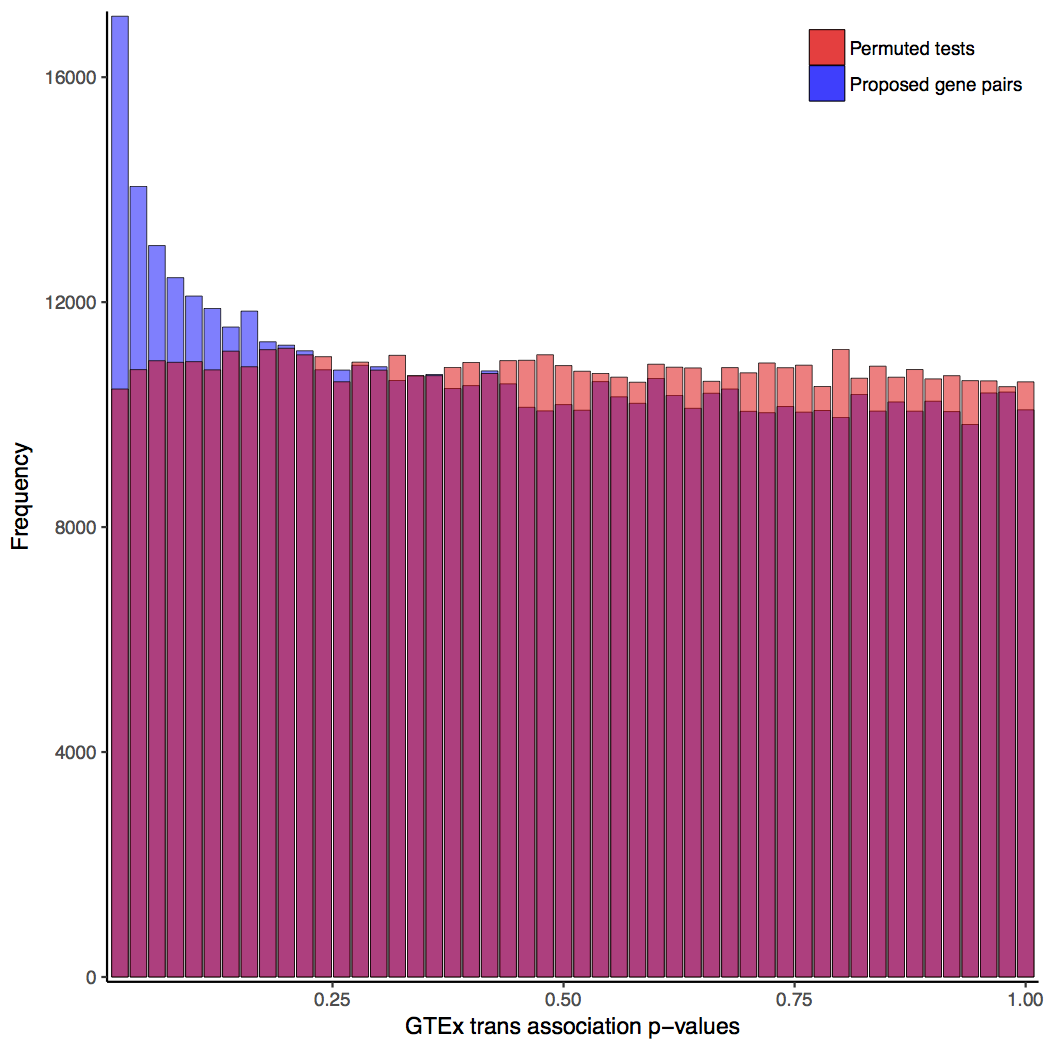

In [7]:
from IPython.display import Image
proj_dir = '/Users/brian_jo/Desktop/Project/RNAseq_pipeline/'
Image(filename = proj_dir+'Analysis/Figures/GGR_validation_plots/0mean-1var_g-null_l-fdr/enet-2_lung_pvalue_hist.png', width=300)

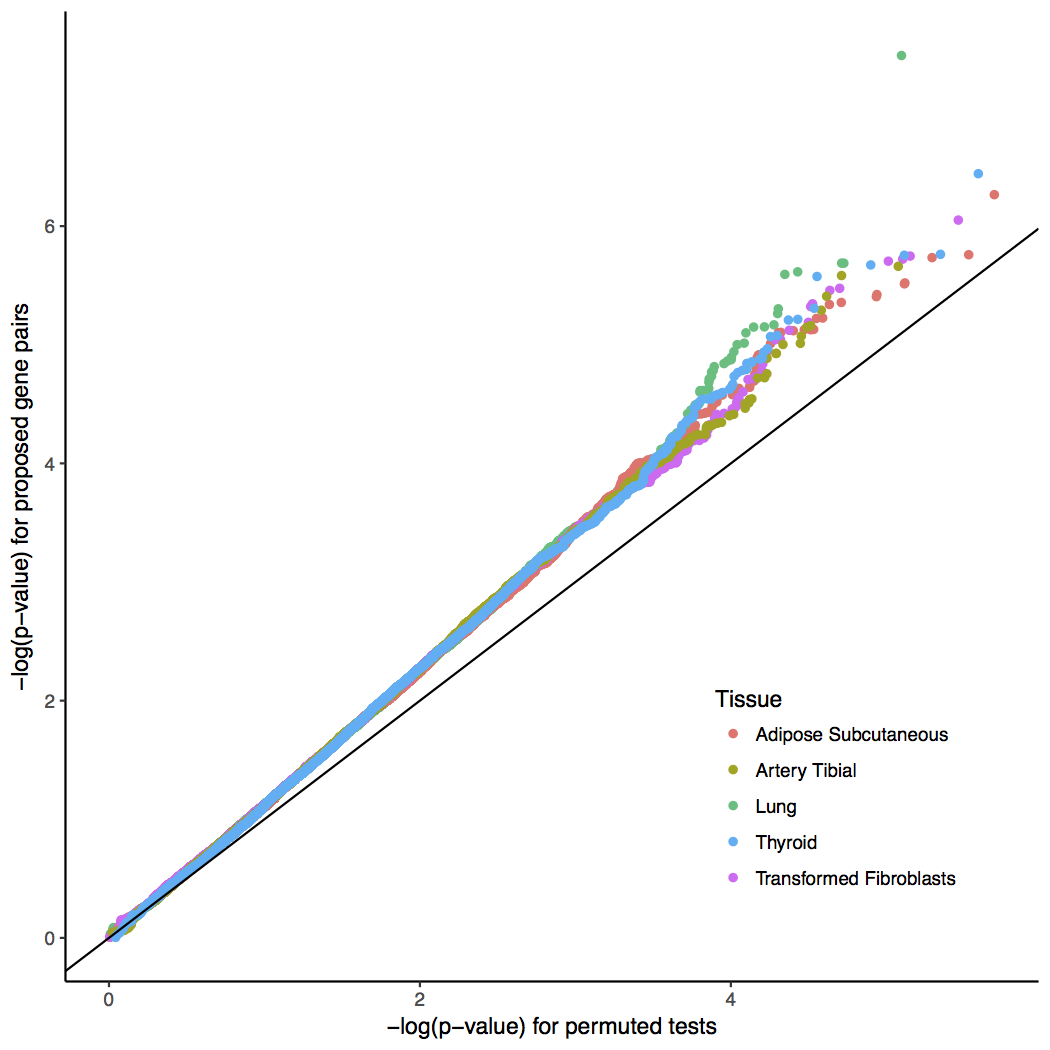

In [8]:
Image(filename = proj_dir+'Analysis/Figures/GGR_validation_plots/0mean-1var_g-null_l-fdr/enet-2_all_tissues_qq_plot.png', width=500)

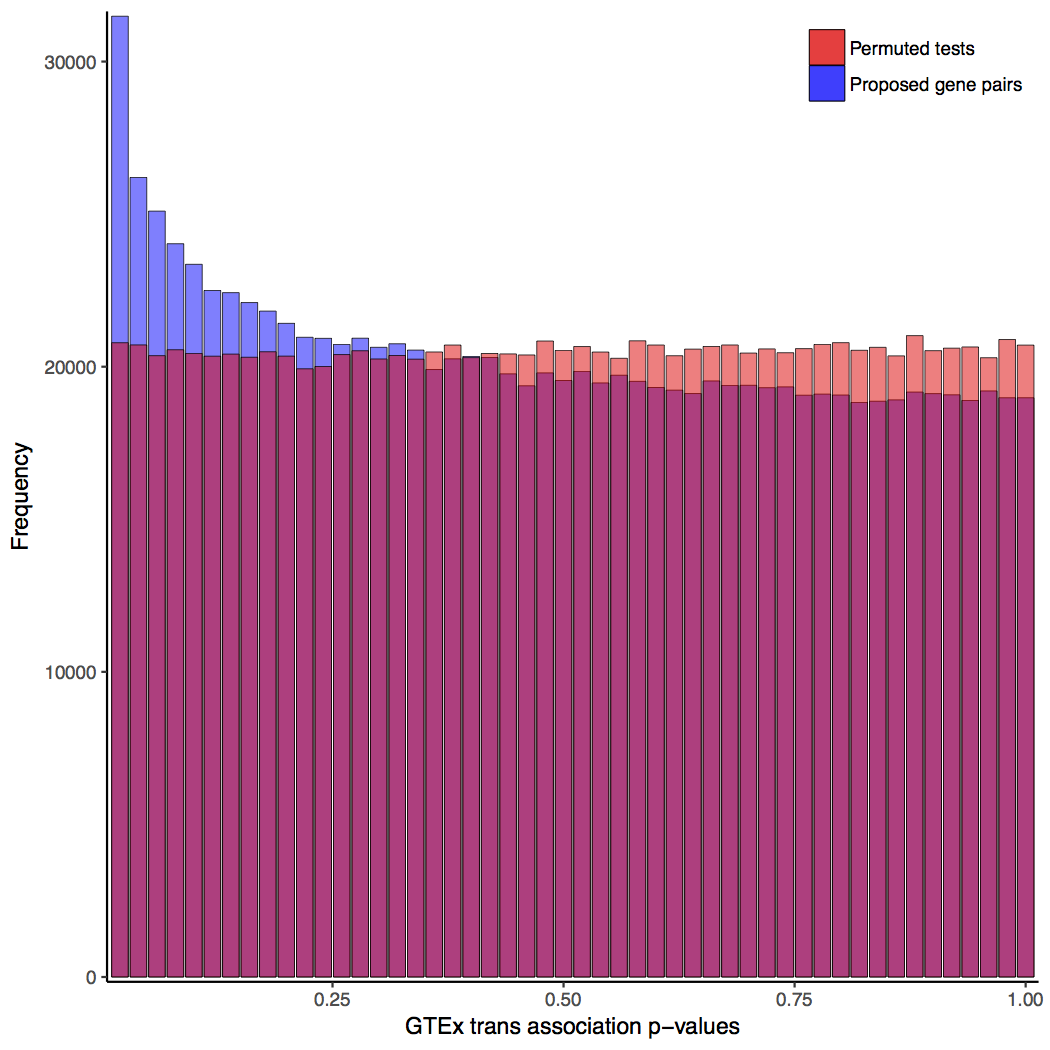

In [9]:
Image(filename = proj_dir+'Analysis/Figures/GGR_validation_plots/0mean-unnormalized_g-null_l-fdr/enet-2_lung_pvalue_hist.png', width=300)

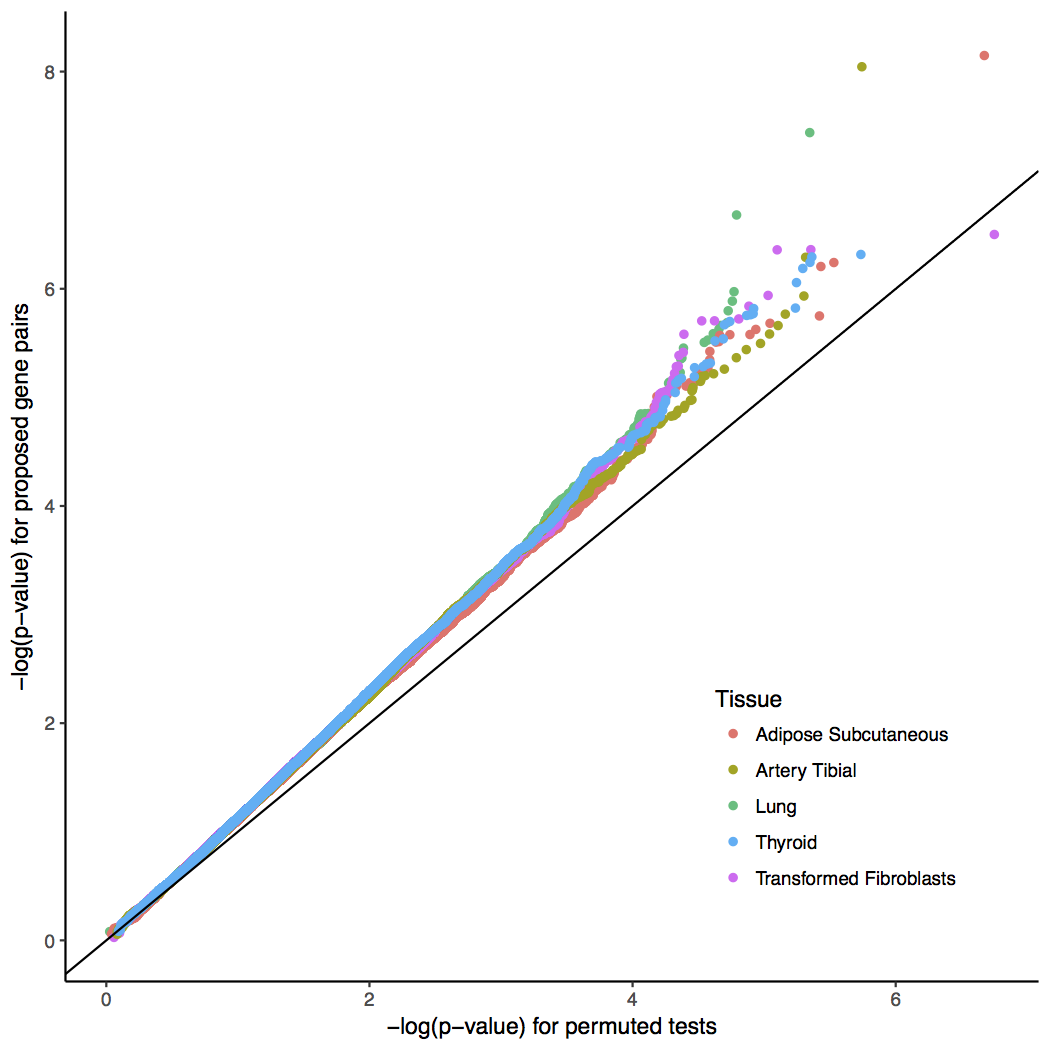

In [10]:
Image(filename = proj_dir+'Analysis/Figures/GGR_validation_plots/0mean-unnormalized_g-null_l-fdr/enet-2_all_tissues_qq_plot.png', width=500)

## Looking at specific gene pairs that are TF-immune, TF-metabolic, and TF-TF

We also want to see whether this trans- analysis has recovered any interesting TF-immune or TF-metabolic cause-effect gene pairs for lung, by looking at TF-immune, TF-metabolic and TF-TF interactions.

Location of interesting edge networks:
<code>
/tigress/BEE/RNAseq/Data/Networks/GGR/priority/analysis/tf-interesting-edge-networks/')
</code>

In [ ]:
%%bash

Rscript /tigress/BEE/RNAseq/Scripts/causality/GGR/gtex/GGR_validation_specific_pairs.R

Three pairs show up as a result, one for each of TF-immune, TF-metabolic, and TF-TF:

<code>
[1] "0mean-1var"
[1] "enet-2"
[1] "tf-metab"
                          Cause.Effect             Cause             Effect
4 ENSG00000213676.9-ENSG00000171132.12 ENSG00000213676.9 ENSG00000171132.12
  Test Lag Weight1 AbsWeight1 Coef1     Weight2 AbsWeight2 Coef2  AbsWeight
4 enet   2      NA         NA    NA -0.07785009 0.07785009     2 0.07785009
  Coef      Weight Gene.Symbol..Cause Gene.Symbol..Effect Summary..Cause
4    2 -0.07785009              ATF6B               PRKCE     TF-Bioguo,
  Summary..Effect trans_SNP statistic       pvalue      beta trans_empPval
4  Diabetes_GSEA, rs9469084  4.186335 3.815811e-05 0.6537666  0.0003335835
   trans_FDR
4 0.07792763


[1] "0mean-unnormalized"
[1] "enet-1"
[1] "tf-tf"
                           Cause.Effect             Cause            Effect
151 ENSG00000164379.5-ENSG00000165512.4 ENSG00000164379.5 ENSG00000165512.4
         Weight  AbsWeight Test Lag Coef Gene.Symbol..Cause Gene.Symbol..Effect
151 -0.04155505 0.04155505 enet   1    1              FOXQ1               ZNF22
    Summary..Cause Summary..Effect trans_SNP statistic       pvalue       beta
151     TF-Bioguo,      TF-Bioguo, rs9391920  -4.41987 1.420863e-05 -0.4151526
    trans_empPval  trans_FDR
151  0.0001534762 0.07426516


[1] "0mean-unnormalized"
[1] "enet-2"
[1] "tf-imm"
                           Cause.Effect             Cause             Effect
65 ENSG00000019549.7-ENSG00000112715.19 ENSG00000019549.7 ENSG00000112715.19
   Test Lag Weight1 AbsWeight1 Coef1    Weight2 AbsWeight2 Coef2  AbsWeight
65 enet   2      NA         NA    NA 0.03810488 0.03810488     2 0.03810488
   Coef     Weight Gene.Symbol..Cause Gene.Symbol..Effect Summary..Cause
65    2 0.03810488              SNAI2               VEGFA     TF-Bioguo,
                                        Summary..Effect trans_SNP statistic
65 Immune_GOC-7,Immune_GOC-6,Immune_GOC-5,Immune_GOC-4, rs1441004 -4.592155
         pvalue       beta trans_empPval  trans_FDR
65 6.673787e-06 -0.3897371  4.327318e-05 0.01832112

We can also plot the eQTL plot and time-series plot for these pairs: